#  Image synthesis from attention model (Lee et al., 2017)
This notebook is intended to synthesize psedo binocular raivalry (Python3).

### Prerequisite 
* OpenCV, 4.1.0.25
* pandas, 2.2.3.2 
* numpy, 1.16.4
* matplotlib, 3.1.0
* seaborn, 0.9.0
* [ffmpeg](https://ffmpeg.org/download.html), 4.2


### Program Procedure in this notebook
1. Import modules
2. Upload peudo binocular rivalry
3. Upload summation neurons' activity
4. Downsample time-course
5. Detect peak points from time courses
6. Add some random num for transitions to the time series
7. Get the order in which the reference images appear
8. generate single images
9. generate parallel images
10. generate multiple parallel images


### After generating images
Under Terminal (MacOS) or Command Prompt (Windows)
```shell
ffmpeg -r 20 -i %04d.jpg grating_random_transition.mp4
```


##### by Dr. Nishida, 2017
##### revised by Hamada Hiroaki, 2019

# 1. Import modules

In [1]:
import cv2
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 2. Upload false binocular rivalry patterns

In [2]:
# upload images
InputDir = ''
n_ref_images = 8
img_list = list()
img_list.append(cv2.imread(InputDir + 'images/Gabor_Left.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_Right.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_Blended_1to4.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_Blended_4to1.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_V.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_Inverse_V.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_Mounted_Left.png'))
img_list.append(cv2.imread(InputDir + 'images/Gabor_Mounted_Right.png'))

In [3]:
print('dimension of each image')
print(img_list[0].shape)

dimension of each image
(600, 600, 3)


In [4]:
img_h, img_w = img_list[0].shape[:2]
base_h = 854
base_w = 1520

img_ext = '.jpg'

x1 = int((base_w / 2 - img_w) / 2)
y1 = int((base_h - img_h) / 2)
x2 = int(x1 + base_w / 2)
y2 = y1

# 3. Upload summation neurons' activity

In [5]:
# load the summation neurons
file = np.loadtxt('summation_120sec.txt', unpack=True)

In [6]:
resp = file[:, 1:]
print(resp.shape)
n_raw_samps = resp.shape[1]

(2, 240000)


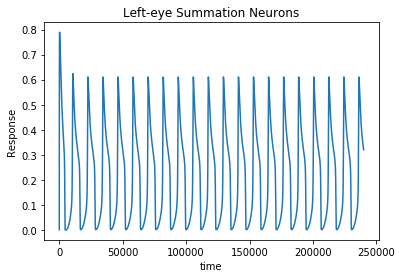

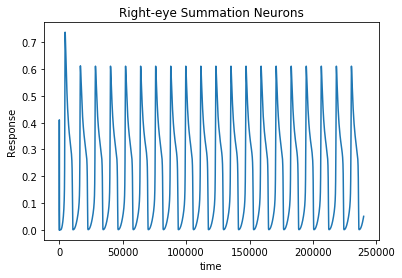

In [7]:
plt.figure(1)
plt.plot(resp[0, :])
plt.xlabel('time'); plt.ylabel('Response');
plt.title('Left-eye Summation Neurons')
plt.figure(2)
plt.plot(resp[1, :])
plt.xlabel('time'); plt.ylabel('Response');
plt.title('Right-eye Summation Neurons')
plt.show()

# 4. Down-sample time-course

2400


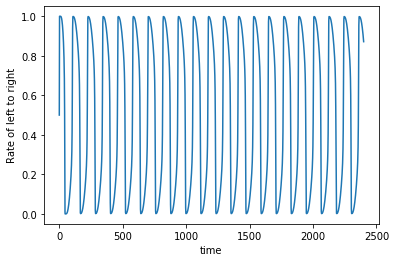

In [8]:
# Get the downsampled timecourse of mixing rate
samp_interval = 100
n_samps = int(n_raw_samps/samp_interval)
tline = np.linspace(0, n_raw_samps-samp_interval, n_samps);
tline = [int(x) for x in tline]
ratio = resp[0, tline] / (resp[0, tline] + resp[1, tline])
print(n_samps)
plt.figure(1)
plt.plot(ratio)
plt.xlabel('time')
plt.ylabel('Rate of left to right')
plt.show()

# 5. Detect peak points from time courses

In [9]:
# Detect the peak points
def detect_PeakPoints(n_samps, ratio):
    peak_points = np.zeros(n_samps)
    for ii in range(1, n_samps-1):
        s1 = ratio[ii] - ratio[ii-1]
        s2 = ratio[ii+1] - ratio[ii]
        
        if s1 > 0 and s2 <= 0:
            peak_points[ii] = 1 # upward peak
        elif s1 < 0 and s2 >= 0:
            peak_points[ii] = -1 # downward peak
            
    # The number of peaks
    n_peak_points = len(np.where(peak_points != 0)[0])
    plt.figure(1)
    plt.plot(peak_points)
    plt.xlabel('time')
    
    return peak_points, n_peak_points    

# 6. Add some random num for transitions to the time series

In [10]:
# this function is intended to add random transition time
def add_random_transition(peak_points, ratio):
    # add random length for the transitions
    # search 
    peaks_where = np.where(abs(peak_points)==1);
    tmp_peak = 0;
    new_ratio = np.zeros(1);
    _, length = np.shape(peaks_where)

    for next_peak in peaks_where[0]:
        # random duration for transition
        random_transition = np.random.randint(0,100);
        a = ratio[next_peak]*np.ones(random_transition)
        b =  np.array(ratio[tmp_peak:next_peak])
        # concatenate original signal and extended peak
        new_concatenate = np.concatenate((b, a))
        new_ratio = np.concatenate((new_ratio, new_concatenate))
        # re-new tmp_peak
        tmp_peak = next_peak
    return new_ratio

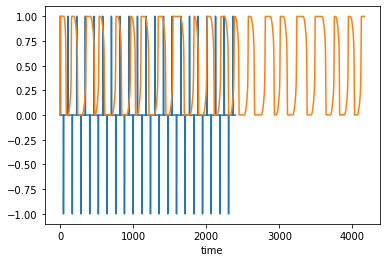

In [11]:
peak_points, n_peak_points = detect_PeakPoints(n_samps, ratio);
new_ratio = add_random_transition(peak_points, ratio)
plt.plot(new_ratio)

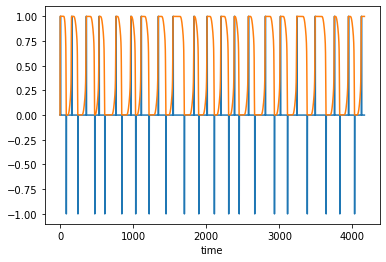

In [12]:
peak_points, n_peak_points = detect_PeakPoints(len(new_ratio), new_ratio);
plt.plot(new_ratio)

# 7. Get the order in which the reference images appear

In [13]:
def get_order(n_elements, n_classes):
    order_list = []

    for ii in range(n_elements):
        while 1:
            rnd = np.floor(np.random.rand(1) * n_classes)
            rnd = int(rnd)

            # Don't permit the same index in successive elements
            if len(order_list) <= 1 or rnd != order_list[ii - 1]:
                order_list.append(rnd)
                break

    # Match the last element to the first element
    order_list.append(order_list[0])
    
    return order_list

# 8. generate single images

In [14]:
def single_images(img_list, img_order, n_samps, InputDir, outdir, ratio):
    pair_i = 1

    img1 = img_list[img_order[0]]
    img2 = img_list[img_order[1]]

    for ii in range(n_samps):
        img1_rate = ratio[ii];
        img2_rate = 1 - ratio[ii];

        if peak_points[ii] != 0:
            pair_i += 1
            if peak_points[ii] == 1:
                img2 = img_list[img_order[pair_i]]
            elif peak_points[ii] == -1:
                img1 = img_list[img_order[pair_i]]
    
        if np.shape(img1) == np.shape(img2):
            dst = cv2.addWeighted(img1, img1_rate, img2, img2_rate, 0)
        else:
            break
        
        merged_img = dst
        cv2.imwrite(InputDir + outdir + ('/%04d' % ii) + img_ext, merged_img)

# 9. generate parallel images

In [15]:
# make a moview with parallel images
def parallel_images(img_list, img_order, n_samps, InputDir, outdir, ratio):
    pair_i = 1

    img1 = img_list[img_order[0]]
    img2 = img_list[img_order[1]]

    for ii in range(n_samps):
        img1_rate = ratio[ii];
        img2_rate = 1 - ratio[ii];

        if peak_points[ii] != 0:
            pair_i += 1
            if peak_points[ii] == 1:
                img2 = img_list[img_order[pair_i]]
            elif peak_points[ii] == -1:
                img1 = img_list[img_order[pair_i]]
    
        if np.shape(img1) == np.shape(img2):
            # merge images
            dst = cv2.addWeighted(img1, img1_rate, img2, img2_rate, 0)
        else:
            break
    
        # overlay the merged images on the background image
        merged_img = np.zeros((base_h, base_w, 3)) + 128
        merged_img[y1:y1+img_h, x1:x1+img_w] = dst
        merged_img[y2:y2+img_h, x2:x2+img_w] = dst
    
        cv2.imwrite(InputDir + outdir + ('/%04d' % ii) + img_ext, merged_img)

# 10. generate multiple parallel images

In [16]:
# get first random images
img_order1 = get_order(n_peak_points + 1, n_ref_images)

InputDir = '';

# decide the location of output
# comments out after first implementation
outdir = '_out'
os.mkdir(InputDir + outdir)

# generate single images
single_images(img_list, img_order1, len(new_ratio), InputDir, outdir, new_ratio)
# generate pararrel images based on single images
parallel_images(img_list, img_order1, len(new_ratio), InputDir, outdir, new_ratio)